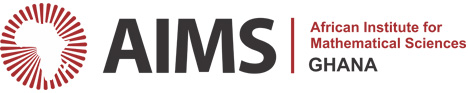

# Group 2 solution for the wine price predection Kaggle competition 

## Data and Setup

#### Import numpy and pandas

In [1]:
import numpy as np
import pandas as pd

#### Import visualisation libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Sklearn imports

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

#### Read the training and testing csv files

In [4]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### Check the head and the info

In [5]:
training_data.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,id
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,PORTUGUESE RED,J. Portugal Ramos,32027
1,France,"A solid, chunky wine, with a structure that is...",NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,71079
2,France,"This is powerful and concentrated, with the hi...",NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,BORDEAUX-STYLE RED BLEND,Château Figeac,32440
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,PETITE SIRAH,Jaffurs,124405
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,ROSé,Syncline,33649


In [6]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 14 columns):
country                  174953 non-null object
description              175000 non-null object
designation              122734 non-null object
points                   175000 non-null float64
price                    175000 non-null float64
province                 174953 non-null object
region_1                 146466 non-null object
region_2                 75394 non-null object
taster_name              65509 non-null object
taster_twitter_handle    62190 non-null object
title                    82189 non-null object
variety                  174999 non-null object
winery                   175000 non-null object
id                       175000 non-null int64
dtypes: float64(2), int64(1), object(11)
memory usage: 18.7+ MB


In [7]:
training_data.describe()

,points,price,id
count,175000.000000,175000.000000,175000.000000
mean,88.083987,34.304400,70684.047240
std,3.157001,38.398146,41341.638798
min,79.636128,4.000000,1.000000
25%,85.971283,16.000000,35020.000000
50%,87.981631,25.000000,70256.500000
75%,90.085631,40.000000,105550.250000
max,100.220603,2500.000000,150929.000000


# EDA

#### Calculate the frequency of null values realtive to actual values in each column

In [8]:
nullFrequency = training_data.isnull().sum()/training_data.isnull().count()*100
nullFrequency

country                   0.026857
description               0.000000
designation              29.866286
points                    0.000000
price                     0.000000
province                  0.026857
region_1                 16.305143
region_2                 56.917714
taster_name              62.566286
taster_twitter_handle    64.462857
title                    53.034857
variety                   0.000571
winery                    0.000000
id                        0.000000
dtype: float64

#### Use a bar plot to visualize the output

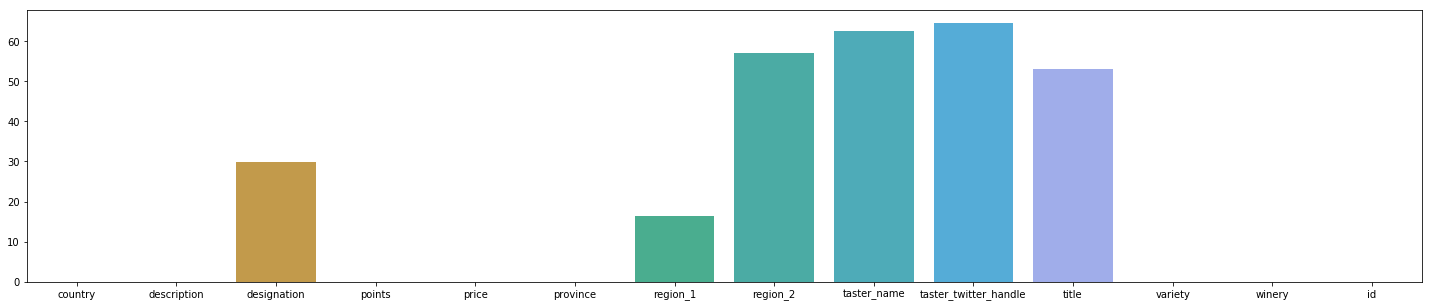

In [12]:
plt.figure(figsize = (25,5))
sns.barplot(x=training_data.columns ,y= nullFrequency.values)

#### Drop the columns with null value frequency > 50%

In [10]:
training_data.drop(['taster_name','taster_twitter_handle','title','region_2','id'],axis = 1,inplace=True)

In [11]:
#same for test data
test_data.drop(['taster_name','taster_twitter_handle','title','region_2','price','id'],axis = 1,inplace=True)

#### Fill the rest with an empty string

In [12]:
training_data = training_data.fillna(value='')

In [13]:
#same for test data
test_data = test_data.fillna(value='')

#### Check the new training data info

In [14]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 9 columns):
country        175000 non-null object
description    175000 non-null object
designation    175000 non-null object
points         175000 non-null float64
price          175000 non-null float64
province       175000 non-null object
region_1       175000 non-null object
variety        175000 non-null object
winery         175000 non-null object
dtypes: float64(2), object(7)
memory usage: 12.0+ MB


# Feature Engineering

#### Encode the text based columns (country, province, variety, winery, region_1, designation) using one hot encoding

In [15]:
#ignore unknown values in testing
enc = OneHotEncoder(handle_unknown='ignore')

In [16]:
X = enc.fit_transform(training_data[['country', 'province', 'variety', 'winery','region_1','designation']])

In [17]:
#same for testing data
X_test_data = enc.transform(test_data[['country', 'province', 'variety', 'winery','region_1','designation']])

#### Add the points column to the one hot encoded features

In [18]:
X[:,1] = training_data['points'].values.reshape(X.shape[0],1)

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:747: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [19]:
#same for test data
X_test_data[:,1] = test_data['points'].values.reshape(X_test_data.shape[0],1)

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:747: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Assign the true values of price to y

In [20]:
y = training_data['price']

## Model selection

### Hyperparamter tuning

In [21]:
objective = "reg:linear"
random_state = 42
n_estimators = 2500
n_jobs = 15
learning_rate = 0.8
max_depth = 8
colsample_bylevel=0.7

In [22]:
xgb_model = xgb.XGBRegressor(
                    objective = objective, 
                    random_state = random_state,
                    n_estimators = n_estimators,
                    n_jobs = n_jobs,
                    learning_rate = learning_rate,
                    max_depth = max_depth,
                    colsample_bylevel = colsample_bylevel)

### Using Kfold cross validation for model training

In [23]:
kfold = KFold(5,True,1)
scores = []
c = 0
for train,test in kfold.split(X):
    print('fold number: ',c)
    c+=1
    X_train,X_test,y_train,y_test = X[train],X[test],training_data['price'][train],training_data['price'][test]
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print(scores[-1])

fold number:  0


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:48:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
17.39089729268924
fold number:  1


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:51:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
19.590315290043055
fold number:  2


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:54:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
17.786210805146258
fold number:  3


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
19.822224170831785
fold number:  4


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:00:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
18.7429199499982


#### Check the predections

In [25]:
predictions = xgb_model.predict(X_test_data)

#### Check for negative values

In [27]:
pre = pd.DataFrame(predictions,columns=['price'])
pre[pre['price']<0].count()

price    34
dtype: int64

In [28]:
pre = pre.apply(lambda x:abs(x))

#### Check the predectid price stats

In [29]:
pre.describe()

,price
count,83210.000000
mean,33.609135
std,35.559753
min,0.003608
25%,17.234845
50%,25.368062
75%,39.866665
max,2474.381592


#### export to csv file for evaluation

In [ ]:
pre.to_csv('wine price predection solution.csv')